In [113]:
import Random
using  Plots, CSV, Gen
using DataFrames: DataFrame
include("../step01-importing-data/DataGen_script.jl")
DF = ReadDF()
xs = DF.Date
ys = DF.DetrendedN1
include("Linear_script.jl")


make_constraints (generic function with 1 method)

In [114]:
@gen function Linear_regression_with_outliers(xs::Vector{<:Real})
    # First, generate some parameters of the model. We make these
    # random choices, because later, we will want to infer them
    # from data. The distributions we use here express our assumptions
    # about the parameters: we think the slope and intercept won't be
    # too far from 0; that the noise is relatively small; and that
    # the proportion of the dataset that don't fit a linear relationship
    # (outliers) could be anything between 0 and 1.
    slope ~ normal(0, 1000)
    intercept ~ normal(0, 1000)
    noise ~ gamma(100, 100)
    prob_outlier ~ uniform(0, 1)
    
    # Next, we generate the actual y coordinates.
    n = length(xs)
    ys = Float64[]
    
    for i = 1:n
        # Decide whether this point is an outlier, and set
        # mean and standard deviation accordingly
        if ({:data => i => :is_outlier} ~ bernoulli(prob_outlier))
            (mu, std) = (0., 1000000)
        else
            (mu, std) = (xs[i] * slope + intercept, noise)
        end
        # Sample a y value for this point
        push!(ys, {:data => i => :y} ~ normal(mu, std))
    end
    ys
end;

In [115]:
function serialize_trace(trace)
    (xs,) = Gen.get_args(trace)
    n = length(xs)
    Dict(:slope => trace[:slope],
         :inlier_std => trace[:noise],
         :points => zip(xs, [trace[:data => i => :y] for i in 1:length(xs)]),
         :xs => xs,
         :ys => [xs[i] * trace[:slope] + trace[:intercept] for i in 1:n],
         :intercept => trace[:intercept],
         :outliers => [trace[:data => i => :is_outlier] for i in 1:length(xs)])
end

serialize_trace (generic function with 1 method)

Used in next sections

In [116]:
function visualize_trace(trace::Trace; title="")
    trace = serialize_trace(trace)
    #Graph points
    outliers = [pt for (pt, outlier) in zip(trace[:points], trace[:outliers]) if outlier]
    inliers =  [pt for (pt, outlier) in zip(trace[:points], trace[:outliers]) if !outlier]
    PLT = Plots.scatter(map(first, inliers), map(last, inliers), markercolor="blue", label=nothing) 
    PLT = Plots.scatter!(map(first, outliers), map(last, outliers), markercolor="red", label=nothing)

    #Graph Line
    PLT = Plots.plot!(trace[:xs], trace[:ys], color = "black", lw = 3, label = nothing)


    #LogPlot
    ExpPLT = Plots.scatter(map(first, inliers), log_modulus.(map(last, inliers)), markercolor="blue", label=nothing) 
    ExpPLT = Plots.scatter!(map(first, outliers), log_modulus.(map(last, outliers)), markercolor="red", label=nothing)
    ExpPLT = Plots.plot!(trace[:xs], log_modulus.(trace[:ys]), color = "black", lw = 3, label = nothing)
    
    DuoPlot = plot(PLT,ExpPLT,title=title)
    return DuoPlot
end

visualize_trace (generic function with 1 method)

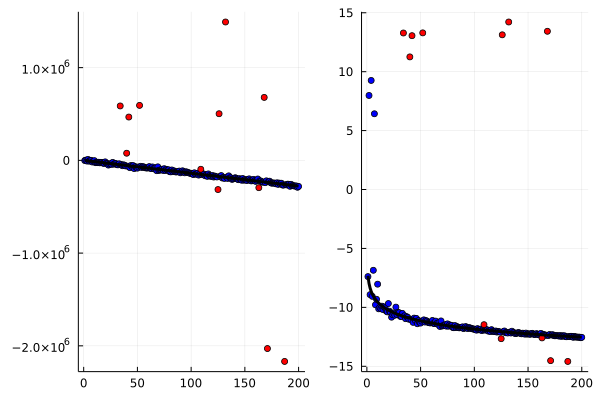

In [147]:
ts = collect(range(1, stop=200, length=200))
traces = Gen.simulate(Linear_regression_with_outliers, (ts,));
visualize_trace(traces)

Used in next sections

In [118]:
function make_constraints(ys::Vector{Float64})
    constraints = Gen.choicemap()
    for i=1:length(ys)
        constraints[:data => i => :y] = ys[i]
    end
    constraints
end;

In [119]:
observations = make_constraints(ys);

In [120]:
# Perform a single block resimulation update of a trace.
function block_resimulation_update(tr)
    # Block 1: Update the line's parameters
    line_params = select(:noise, :slope, :intercept)
    (tr, _) = mh(tr, line_params)
    
    # Blocks 2-N+1: Update the outlier classifications
    (xs,) = get_args(tr)
    n = length(xs)
    for i=1:n
        (tr, _) = mh(tr, select(:data => i => :is_outlier))
    end
    
    # Block N+2: Update the prob_outlier parameter
    (tr, _) = mh(tr, select(:prob_outlier))
    
    # Return the updated trace
    tr
end;

┌ Info: Saved animation to 
│   fn = C:\Users\marli\AppData\Local\Temp\jl_BUPVeyha67.gif
└ @ Plots C:\Users\marli\.julia\packages\Plots\rDbWY\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\marli\\AppData\\Local\\Temp\\jl_BUPVeyha67.gif")
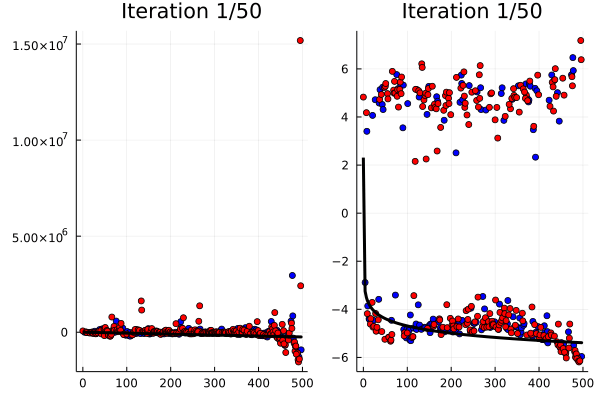

In [121]:
t, = generate(Linear_regression_with_outliers, (xs,), observations)
dur = 50
viz = Plots.@animate for i in 1:dur
    global t
    t = block_resimulation_update(t)
    visualize_trace(t; title="Iteration $i/$dur")
end;
gif(viz)